In [2]:
import argparse, random, os, math, time
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Batch Normalization (BN) — Theory & Practice

## Problem
- Deep networks often suffer from **internal covariate shift**: the distribution of activations keeps changing layer to layer as parameters update.  
- This makes training slower, requires careful initialization, and often leads to vanishing/exploding gradients.  
- Networks without normalization can also be highly sensitive to learning rate choices.

## Core Idea
- Normalize activations within a mini-batch to have mean ≈ 0 and variance ≈ 1.  
- Then allow the network to learn **scaling (γ)** and **shifting (β)** parameters so it can recover original distributions if needed.  

### Formula
For each feature:
$$
\mu = \frac{1}{N}\sum_i x_i, \quad \sigma^2 = \frac{1}{N}\sum_i (x_i - \mu)^2
$$
Normalize:
$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$
Scale and shift:
$$
y_i = \gamma \hat{x}_i + \beta
$$

where:

- $\mu_B, \sigma_B^2$: batch mean and variance  
- $\epsilon$: small stabilizer  
- $\gamma, \beta$: learnable affine parameters  


## Training vs Inference
- Train: use batch stats above.
- Inference: use running EMA accumulated during training:

$$
\mu_t=(1-\alpha)\mu_{t-1}+\alpha\,\mu_B,\qquad
\sigma_t^2=(1-\alpha)\sigma_{t-1}^2+\alpha\,\sigma_B^2
$$


- **Training:** use mini-batch statistics (mean & variance).  
- **Inference:** use running (exponentially averaged) statistics accumulated during training.  

---

## Benefits
- Allows **higher learning rates**, improving convergence speed.  
- Acts as a **regularizer**, reducing need for dropout in many cases.  
- Makes optimization landscapes smoother, helping deeper nets train reliably.  

## Limitations
- **Dependence on batch size**: small batches yield noisy estimates of mean/var.  
- **Sequential/online data**: hard to apply when batch stats are not available.  
- **Recurrent models**: less effective since temporal correlations break the i.i.d. assumption.  
- **Inference mismatch**: discrepancy between batch stats (train) and running stats (test) can hurt generalization.  

## Variants / Alternatives
- **LayerNorm**: normalizes across features per sample (good for RNNs/Transformers).  
- **InstanceNorm / GroupNorm**: address small-batch or style transfer settings.  
- **WeightNorm**: normalize weights instead of activations.


# Layer Normalization (LN) — Theory & Practice

## Problem
- **BatchNorm** depends on batch statistics → unstable or unusable for:
  - Small batch sizes  
  - Variable-length sequences (RNNs)  
  - Online/streaming data  
- Need a method that **normalizes independently per sample**, not across the batch.  

---

## Core Idea
- Normalize activations **across features of a single sample**, instead of across the batch.  
- Works consistently regardless of batch size.  

For input vector \(x \in \mathbb{R}^d\):  

$$
\mu = \frac{1}{d}\sum_{i=1}^{d} x_i, \qquad
\sigma^2 = \frac{1}{d}\sum_{i=1}^{d}(x_i - \mu)^2
$$  

Then normalize:  

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \qquad
y_i = \gamma \hat{x}_i + \beta
$$  

where:  
- \(d\): number of features (per sample)  
- \(\mu, \sigma^2\): feature mean & variance (per sample)  
- \(\epsilon\): numerical stabilizer  
- \(\gamma, \beta\): learnable affine parameters  

---

## Training vs Inference
- **No distinction**: LN always uses the current sample’s statistics.  
- No running averages are required → inference behaves the same as training.  

---

## Benefits
- Works with **very small batches** (even batch size = 1).  
- Particularly effective for **RNNs** and **Transformers**, where sequence lengths vary.  
- Removes train/test mismatch (no running statistics).  
- Often stabilizes very deep models.  

---

## Limitations
- Computationally more expensive than BN in CNNs (since LN must compute stats per sample).  
- Less effective in convolutional vision models, where spatial correlation makes BN more suitable.  
- Doesn’t provide the same “regularization effect” that BN does in CNNs.  

---

## Variants / Alternatives
- **BatchNorm**: better for large-batch CNN training.  
- **InstanceNorm**: normalizes per-channel per-sample (used in style transfer).  
- **GroupNorm**: compromise; normalizes within groups of channels (batch-size agnostic, works well in vision).  
- **RMSNorm**: removes mean normalization, normalizes only by variance (used in some Transformers).  


In [1]:
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()


In [ ]:
# -----------------------
# Blocks
# -----------------------
class ConvBlockBN(nn.Module):

    def __init__(self, in_ch, out_ch, use_bn=True):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class ConvBlockLN(nn.Module):

    def __init__(self, in_ch, out_ch, use_ln=True):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=True)
        self.use_ln = use_ln
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.use_ln:
            N, C, H, W = x.shape

            # normalize per-sample across features
            x = F.layer_norm(x, [C, H, W])
        return self.act(x)

In [ ]:
# -----------------------
# Models
# -----------------------
class SmallConvNetBN(nn.Module):

    def __init__(self, num_classes=10, use_bn=True):
        super().__init__()
        self.block1 = nn.Sequential(
            ConvBlockBN(3, 32, use_bn),
            ConvBlockBN(32, 32, use_bn),
            nn.MaxPool2d(2),  # 32->16
        )
        self.block2 = nn.Sequential(
            ConvBlockBN(32, 64, use_bn),
            ConvBlockBN(64, 64, use_bn),
            nn.MaxPool2d(2),  # 16->8
        )
        self.block3 = nn.Sequential(
            ConvBlockBN(64, 128, use_bn),
            ConvBlockBN(128, 128, use_bn),
            nn.MaxPool2d(2),  # 8->4
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x)
        return self.head(x)


class SmallConvNetLN(nn.Module):

    def __init__(self, num_classes=10, use_ln=True):
        super().__init__()
        self.block1 = nn.Sequential(
            ConvBlockLN(3, 32, use_ln),
            ConvBlockLN(32, 32, use_ln),
            nn.MaxPool2d(2),  # 32->16
        )
        self.block2 = nn.Sequential(
            ConvBlockLN(32, 64, use_ln),
            ConvBlockLN(64, 64, use_ln),
            nn.MaxPool2d(2),  # 16->8
        )
        self.block3 = nn.Sequential(
            ConvBlockLN(64, 128, use_ln),
            ConvBlockLN(128, 128, use_ln),
            nn.MaxPool2d(2),  # 8->4
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x)
        return self.head(x)


In [ ]:
# -----------------------
# Training / Eval
# -----------------------

@torch.no_grad()
def evaluate(model, loader, device):

    model.eval()
    tot_acc, tot_loss, n = 0.0, 0.0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        b = xb.size(0)
        tot_loss += loss.item() * b
        tot_acc  += (logits.argmax(1) == yb).sum().item()
        n += b
    return tot_loss / n, tot_acc / n

In [ ]:
def train_one(model, optimizer, scaler, loader, device, grad_clip=None):

    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=device.type=='cuda'):
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            scaler.scale(loss).backward()
            if grad_clip:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        b = xb.size(0)
        tot_loss += loss.item() * b
        tot_acc  += (logits.argmax(1) == yb).sum().item()
        n += b
    return tot_loss / n, tot_acc / n

In [ ]:
# -----------------------
# Data
# -----------------------
def get_loaders(data_dir, batch_size, num_workers):

    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_ds = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_tf)
    test_ds  = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_tf)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=2*batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader


In [ ]:
# -----------------------
# Run experiment
# -----------------------
def run_experiment(args, mode: str):
    set_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = True

    train_loader, test_loader = get_loaders(args.data_dir, args.batch_size, args.num_workers)

    if mode == "BN":
        model = SmallConvNetBN(num_classes=10, use_bn=True).to(device)
    elif mode == "NoNorm":
        model = SmallConvNetBN(num_classes=10, use_bn=False).to(device)
    elif mode == "LN":
        model = SmallConvNetLN(num_classes=10, use_ln=True).to(device)
    else:
        raise ValueError(f"Unknown mode {mode}")


    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
    scaler = torch.cuda.amp.GradScaler() if device.type=='cuda' else None


    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, args.epochs+1):

        tr_loss, tr_acc = train_one(model, optimizer, scaler, train_loader, device, grad_clip=1.0)
        va_loss, va_acc = evaluate(model, test_loader, device)

        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        print(f"{mode} | epoch {epoch:02d}/{args.epochs} | "
              f"train_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f}")
    return hist


In [ ]:
# -----------------------
# Plot
# -----------------------
def plot_hist(h_bn, h_nbn, h_ln, out_png):
    epochs = range(1, len(h_bn["train_loss"])+1)

    # Loss
    plt.figure()
    plt.plot(epochs, h_bn["train_loss"], label="BN train")
    plt.plot(epochs, h_bn["val_loss"], label="BN val")
    plt.plot(epochs, h_nbn["train_loss"], label="NoNorm train")
    plt.plot(epochs, h_nbn["val_loss"], label="NoNorm val")
    plt.plot(epochs, h_ln["train_loss"], label="LN train")
    plt.plot(epochs, h_ln["val_loss"], label="LN val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch"); plt.legend()
    plt.tight_layout()
    plt.savefig(out_png.replace(".png","_loss.png"), dpi=160)

    # Accuracy
    plt.figure()
    plt.plot(epochs, h_bn["train_acc"], label="BN train")
    plt.plot(epochs, h_bn["val_acc"], label="BN val")
    plt.plot(epochs, h_nbn["train_acc"], label="NoNorm train")
    plt.plot(epochs, h_nbn["val_acc"], label="NoNorm val")
    plt.plot(epochs, h_ln["train_acc"], label="LN train")
    plt.plot(epochs, h_ln["val_acc"], label="LN val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch"); plt.legend()
    plt.tight_layout()
    plt.savefig(out_png.replace(".png","_acc.png"), dpi=160)

100%|██████████| 170M/170M [11:38<00:00, 244kB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BN | epoch 01/5 | train_loss 1.3599 acc 0.506 | val_loss 1.1289 acc 0.599
BN | epoch 02/5 | train_loss 0.9613 acc 0.661 | val_loss 0.9453 acc 0.668
BN | epoch 03/5 | train_loss 0.8099 acc 0.713 | val_loss 0.7764 acc 0.725
BN | epoch 04/5 | train_loss 0.7263 acc 0.748 | val_loss 0.7057 acc 0.755
BN | epoch 05/5 | train_loss 0.6589 acc 0.770 | val_loss 0.6726 acc 0.768
NoNorm | epoch 01/5 | train_loss 1.8125 acc 0.328 | val_loss 1.4881 acc 0.444
NoNorm | epoch 02/5 | train_loss 1.4708 acc 0.457 | val_loss 1.3723 acc 0.496
NoNorm | epoch 03/5 | train_loss 1.3281 acc 0.517 | val_loss 1.1687 acc 0.582
NoNorm | epoch 04/5 | train_loss 1.2049 acc 0.567 | val_loss 1.1001 acc 0.612
NoNorm | epoch 05/5 | train_loss 1.0973 acc 0.607 | val_loss 1.0155 acc 0.634
LN | epoch 01/5 | train_loss 1.6502 acc 0.391 | val_loss 1.2812 acc 0.532
LN | epoch 02/5 | train_loss 1.2294 acc 0.557 | val_loss 1.0386 acc 0.625
LN | epoch 03/5 | train_loss 1.0471 acc 0.625 | val_loss 1.0576 acc 0.626
LN | epoch 04/5 | 

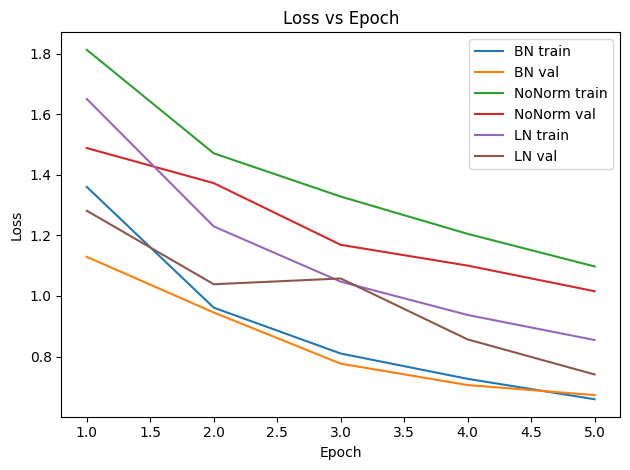

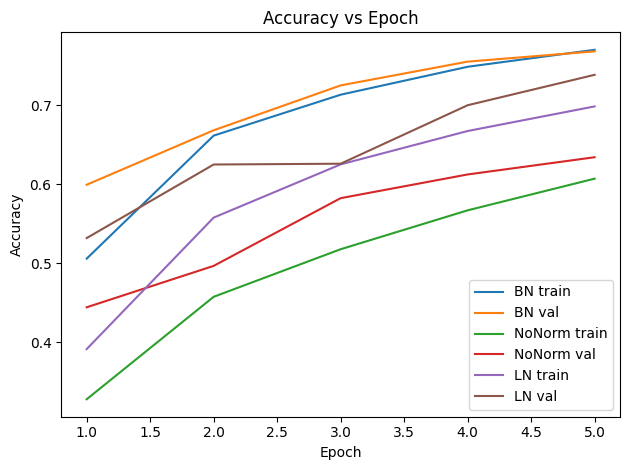

In [ ]:
class Args:
    data_dir = "./data"
    epochs = 5
    batch_size = 128
    lr = 3e-4
    wd = 5e-4
    num_workers = 2
    seed = 42
    out = "norm_compare.png"

args = Args()
h_bn = run_experiment(args, mode="BN")
h_nbn = run_experiment(args, mode="NoNorm")
h_ln = run_experiment(args, mode="LN")
plot_hist(h_bn, h_nbn, h_ln, args.out)

# SUMMARY - Types of Normalization in Deep Learning

## 1️⃣ Batch Normalization (BN)
- **Normalizes:** across batch dimension and feature channels.  
  $$ \mu = \frac{1}{m}\sum_i x_i, \quad \sigma^2 = \frac{1}{m}\sum_i (x_i - \mu)^2 $$
- **Best for:** CNNs and feedforward nets with large batches.  
- **Limitation:** depends on batch statistics → unstable for small batch sizes or RNNs.

---

## 2️⃣ Layer Normalization (LN)
- **Normalizes:** across features of a **single sample** (no batch dependence).  
- **Best for:** Transformers, RNNs, or variable-length sequences.  
- **Limitation:** doesn’t account for interactions between samples in a batch.

---

## 3️⃣ Instance Normalization (IN)
- **Normalizes:** each feature map *per instance*, often in CNNs.  
- Common in **style transfer** and **image generation** tasks.
- Formula similar to BN but computed independently for each sample and channel.

---

## 4️⃣ Group Normalization (GN)
- **Normalizes:** groups of channels within each sample.  
- Sits between LayerNorm and InstanceNorm.  
- **Best for:** CNNs with small batch sizes (e.g., detection, segmentation).  
- Introduced in *“Group Normalization” (Wu & He, 2018)*.

---

## 5️⃣ Weight Normalization (WN)
- **Idea:** Reparameterize weights as  
  $$ w = g \cdot \frac{v}{\|v\|} $$
  to decouple magnitude and direction.  
- **Best for:** stabilizing training, especially in RNNs.  
- No dependence on batch statistics — purely parameter-level normalization.

---

## 6️⃣ RMSNorm (Root Mean Square Norm)
- **Simplified LayerNorm:** removes the mean subtraction step.  
  $$ \text{RMSNorm}(x) = \frac{x}{\sqrt{\text{mean}(x^2) + \epsilon}} \cdot \gamma $$
- **Used in:** GPT-NeoX, LLaMA, and many modern transformer models for efficiency.

---

## 🧩 Summary Table

| Method | Normalizes Over | Batch Dependent | Typical Use |
|--------|-----------------|-----------------|--------------|
| **BatchNorm** | Batch + Features | ✅ Yes | CNNs |
| **LayerNorm** | Features (per sample) | ❌ No | Transformers, RNNs |
| **InstanceNorm** | Per-channel (per sample) | ❌ No | Style transfer |
| **GroupNorm** | Group of channels | ❌ No | Small-batch CNNs |
| **WeightNorm** | Weight vectors | ❌ No | RNNs, stability |
| **RMSNorm** | Features (no mean) | ❌ No | Transformers (modern) |

---

✅ **Expert note:**  
Modern LLMs (GPT-3+, LLaMA, DeepSeek, etc.) typically use **RMSNorm or LayerNorm**, not BatchNorm — because they train with small effective batch sizes (per device) and sequence-based data.
